In [24]:
# %% [markdown]
# Parameter-sweep loader + plots (ARCOS eval summaries)
# - Loads all summary_bbox_*.csv
# - Parses params from directory names like:
#   <BASE_DIR>/<sim>_snr_<snr>/eps<EPS>_min<MIN>_ds<DS>_nprev<N>/{ITER}_RES_<tracker>/
#   and file names like: summary_bbox_<iou>_<ITER>_<tracker>.csv
# - Produces a tidy DataFrame and plotting helpers (matplotlib only)

# %%
import re, os, glob, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Optional, Iterable

# ----------- config ------------
BASE_DIR = "run_slurm"   # <-- set this to your output root
METRICS_DEFAULT = ["mota", "motp", "precision", "recall"]
# -------------------------------

# robust-ish regexes for your layout
RE_SIM_SNR   = re.compile(r"(?P<sim>[^/]+)_snr_(?P<snr>[^/]+)")
RE_PARAM_TAG = re.compile(r"eps(?P<eps>[^_]+)_min(?P<min>\d+)_ds(?P<ds>\d+)_nprev(?P<nprev>\d+)")
RE_SUMMARY   = re.compile(r"summary_bbox_(?P<iou>[\d\.]+)_(?P<iter>\d+)?_(?P<tracker>[a-zA-Z0-9_]+)\.csv$")

def _coerce_float(x: str):
    try:
        if x.lower() == "inf":
            return np.inf
    except AttributeError:
        pass
    try:
        return float(x)
    except Exception:
        return x

def parse_context(path: Path) -> Optional[Dict]:
    """
    Parse sim/snr and eps/min/ds/nprev from parent dirs,
    and iou/iter/tracker from filename.
    """
    p = path.resolve()
    # filename bits
    msum = RE_SUMMARY.search(p.name)
    if not msum:
        return None
    iou = float(msum.group("iou"))
    tracker = msum.group("tracker")
    iter_str = msum.group("iter")
    iteration = int(iter_str) if (iter_str and iter_str.isdigit()) else None

    # parent dirs: summary_bbox_* lives in: .../<sim>_snr_<snr>/eps.../  (i.e., params dir)
    params_dir = p.parent
    simsnr_dir = params_dir.parent

    mtag = RE_PARAM_TAG.search(params_dir.name)
    msn  = RE_SIM_SNR.match(simsnr_dir.name)
    if not (mtag and msn):
        return None

    ctx = {
        "sim_function": msn.group("sim"),
        "snr": _coerce_float(msn.group("snr")),
        "eps": mtag.group("eps"),                 # keep as string (may be "auto")
        "min_clustersize": int(mtag.group("min")),
        "downsample": int(mtag.group("ds")),
        "n_prev": int(mtag.group("nprev")),
        "iteration": iteration,
        "tracker_name": tracker,
        "iou_threshold": iou,
        "summary_path": str(p),
    }
    # if eps is numeric, store numeric variant too
    try:
        ctx["eps_numeric"] = float(ctx["eps"])
    except Exception:
        ctx["eps_numeric"] = np.nan
    return ctx

def load_all_summaries(base_dir: str) -> pd.DataFrame:
    files = glob.glob(os.path.join(base_dir, "**", "summary_bbox_0.5*.csv"), recursive=True)
    if not files:
        raise FileNotFoundError(f"No summary_bbox_*.csv found under {base_dir}")
    print(f"Found {len(files)} summary files under {base_dir}")
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # handle both cases: metric columns in row or in columns
        # motmetrics often returns a 1-row DataFrame with index=tag/name
        df = df.copy()
        dfs.append(df)


    if not dfs:
        raise RuntimeError("Found files, but none matched expected structure/regex parsing.")
    tidy = pd.concat(dfs, ignore_index=True)

    # normalize columns: lowercase for safety
    tidy.columns = [c.strip() for c in tidy.columns]
    return tidy

# tidy up eps for plotting order: put "auto" at the end
def _eps_sort_key(val):
    try:
        return (0, float(val))
    except Exception:
        return (1, np.inf)


# %%
# ---------- helpers: filters & aggregation ----------
def filter_df(df: pd.DataFrame,
              sim: Optional[str]=None,
              snr: Optional[str]=None,
              tracker: Optional[str]=None,
              n_prev: Optional[int]=None,
              ds: Optional[int]=None) -> pd.DataFrame:
    m = df
    if sim is not None:     m = m[m["sim_function"] == sim]
    if snr is not None:     m = m[m["snr"].astype(str) == str(snr)]
    if tracker is not None: m = m[m["tracker_name"] == tracker]
    if n_prev is not None:  m = m[m["n_prev"] == n_prev]
    if ds is not None:      m = m[m["downsample"] == ds]
    return m

def agg_across_iterations(m: pd.DataFrame,
                          by=("sim_function","snr","tracker_name","eps","min_clustersize","n_prev","downsample"),
                          metrics: Iterable[str]=METRICS_DEFAULT):
    g = m.groupby(list(by), dropna=False)
    agg_dict = {k:["mean","std","count"] for k in metrics if k in m.columns}
    out = g.agg(agg_dict)
    # flatten columns
    out.columns = [f"{a}_{b}" for a,b in out.columns]
    out = out.reset_index()
    return out

# %%
# ---------- plotting: line sweeps ----------
def plot_line_sweep(m: pd.DataFrame,
                    metric="mota",
                    x="eps",
                    hue="min_clustersize",
                    title=None):
    # Prepare series grouped by hue
    levels = sorted(m[hue].unique())
    x_vals = sorted(m[x].unique(), key=lambda v: _eps_sort_key(v) if x=="eps" else v)
    plt.figure(figsize=(8,5))
    for h in levels:
        sub = m[m[hue]==h]
        # ensure x ordering
        sub = sub.set_index(x).reindex(x_vals).reset_index()
        y = sub[f"{metric}_mean"] if f"{metric}_mean" in sub else sub[metric]
        yerr = sub[f"{metric}_std"] if f"{metric}_std" in sub else None
        label = f"{hue}={h}"
        if yerr is not None and not np.all(np.isnan(yerr)):
            plt.errorbar(sub[x], y, yerr=yerr, marker="o", label=label)
        else:
            plt.plot(sub[x], y, marker="o", label=label)
    plt.xlabel(x)
    plt.ylabel(metric.upper())
    plt.title(title or f"{metric.upper()} vs {x}")
    plt.legend()
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# %%
# ---------- plotting: heatmap (eps × min_clustersize) ----------
def plot_heatmap(m: pd.DataFrame,
                 metric="mota",
                 title=None,
                 vmin=0, vmax=1):
    # pivot on eps (columns) and min_clustersize (rows)
    # sort eps with numeric first then "auto"
    cols = sorted(m["eps"].unique(), key=_eps_sort_key)
    rows = sorted(m["min_clustersize"].unique())
    P = m.pivot_table(index="min_clustersize", columns="eps",
                      values=f"{metric}_mean" if f"{metric}_mean" in m.columns else metric,
                      aggfunc="mean").reindex(index=rows, columns=cols)
    fig = plt.figure(figsize=(0.5*len(cols), 0.5*len(rows)))
    im = plt.imshow(P.values, aspect="equal", origin="lower", vmin=vmin, vmax=vmax, cmap="viridis")
    plt.colorbar(im, fraction=0.046, pad=0.04, label=metric.upper())
    plt.yticks(range(len(rows)), rows)
    plt.xticks(range(len(cols)), cols, rotation=0)
    plt.ylabel("min_clustersize")
    plt.xlabel("eps")
    plt.title(title or f"{metric.upper()} heatmap")
    plt.tight_layout()
    return fig



In [2]:
df = load_all_summaries(BASE_DIR)
print(f"Loaded {len(df)} rows from {BASE_DIR}")
display(df.head())

# %%
# # Ensure useful dtypes
# if "mota" in df.columns:
#     pass
# else:
#     # try common casing
#     for alt in ["MOTA","MotA"]:
#         if alt in df.columns:
#             df["mota"] = df[alt]
#             break
# for col in ["precision","recall","motp"]:
#     if col not in df.columns:
#         for alt in [col.upper(), col.capitalize()]:
#             if alt in df.columns:
#                 df[col] = df[alt]
#                 break

Found 1120 summary files under run_slurm
Loaded 1120 rows from run_slurm


,num_frames,mota,motp,num_switches,num_false_positives,num_misses,num_detections,num_objects,num_predictions,precision,...,tracker_name,sim_function,snr,size_threshold,iou_threshold,iteration,eps,min_clustersize,n_prev,downsample
0,500,0.0,NaN,0,0,4417,0,4417,0,NaN,...,arcospx,sim_circles,inf,1,0.5,0,1.2,128,1,1
1,500,0.0,NaN,0,0,3262,0,3262,0,NaN,...,arcospx,sim_circles,inf,1,0.5,1,1.2,128,1,1
2,500,0.0,NaN,0,0,3389,0,3389,0,NaN,...,arcospx,sim_circles,inf,1,0.5,2,1.2,128,1,1
3,500,0.0,NaN,0,0,3706,0,3706,0,NaN,...,arcospx,sim_circles,inf,1,0.5,3,1.2,128,1,1
4,500,0.0,NaN,0,0,3377,0,3377,0,NaN,...,arcospx,sim_circles,inf,1,0.5,4,1.2,128,1,1


In [3]:
df.to_csv("run_slurm/all_summaries_tidy.csv", index=False)

In [10]:
df["eps_order"] = df["eps"].apply(_eps_sort_key)

In [11]:
# %%
# ======== Example usage =========
# Pick a slice: one sim, one snr, one tracker, fixed n_prev & ds
SIM = df["sim_function"].iloc[0] if len(df) else "sim_circles"
SNR = str(df["snr"].iloc[0]) if len(df) else "inf"
TRACKER = "arcospx"  # or "trackmate"
N_PREV = 1
DS = 1

slice_df = filter_df(df.query('eps != "auto"'), sim=SIM, snr=SNR, tracker=TRACKER, n_prev=N_PREV, ds=DS)
agg = agg_across_iterations(slice_df, metrics=METRICS_DEFAULT)

print(f"{SIM=} {SNR=} {TRACKER=}  rows={len(slice_df)}  combos={agg.shape[0]}")
display(agg.head())




SIM='sim_circles' SNR='inf' TRACKER='arcospx'  rows=1050  combos=196


,sim_function,snr,tracker_name,eps,min_clustersize,n_prev,downsample,mota_mean,mota_std,mota_count,motp_mean,motp_std,motp_count,precision_mean,precision_std,precision_count,recall_mean,recall_std,recall_count
0,sim_circles,inf,arcospx,1.2,1,1,1,0.975612,0.018695,5,0.020706,0.006567,5,0.988177,0.008053,5,0.987408,0.010750,5
1,sim_circles,inf,arcospx,1.2,2,1,1,0.751842,0.105398,5,0.057688,0.011882,5,0.832309,0.072354,5,0.949838,0.015222,5
2,sim_circles,inf,arcospx,1.2,3,1,1,0.807771,0.081137,5,0.042158,0.015201,5,0.872739,0.058447,5,0.950099,0.009990,5
3,sim_circles,inf,arcospx,1.2,4,1,1,0.819552,0.073320,5,0.036088,0.007686,5,0.885796,0.056702,5,0.945142,0.013881,5
4,sim_circles,inf,arcospx,1.2,6,1,1,0.623640,0.279002,5,0.064426,0.013690,5,0.780592,0.147974,5,0.922606,0.019322,5


In [12]:
agg

,sim_function,snr,tracker_name,eps,min_clustersize,n_prev,downsample,mota_mean,mota_std,mota_count,motp_mean,motp_std,motp_count,precision_mean,precision_std,precision_count,recall_mean,recall_std,recall_count
0,sim_circles,inf,arcospx,1.2,1,1,1,0.975612,0.018695,5,0.020706,0.006567,5,0.988177,0.008053,5,0.987408,0.010750,5
1,sim_circles,inf,arcospx,1.2,2,1,1,0.751842,0.105398,5,0.057688,0.011882,5,0.832309,0.072354,5,0.949838,0.015222,5
2,sim_circles,inf,arcospx,1.2,3,1,1,0.807771,0.081137,5,0.042158,0.015201,5,0.872739,0.058447,5,0.950099,0.009990,5
3,sim_circles,inf,arcospx,1.2,4,1,1,0.819552,0.073320,5,0.036088,0.007686,5,0.885796,0.056702,5,0.945142,0.013881,5
4,sim_circles,inf,arcospx,1.2,6,1,1,0.623640,0.279002,5,0.064426,0.013690,5,0.780592,0.147974,5,0.922606,0.019322,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,sim_circles,inf,arcospx,40.0,32,1,1,0.739364,0.094325,10,0.040966,0.017506,10,0.957040,0.033485,10,0.772910,0.073902,10
192,sim_circles,inf,arcospx,40.0,48,1,1,0.727055,0.100758,5,0.042097,0.018524,5,0.959158,0.032773,5,0.758072,0.080668,5
193,sim_circles,inf,arcospx,40.0,64,1,1,0.706520,0.114142,10,0.044064,0.017643,10,0.946123,0.052984,10,0.747859,0.080020,10
194,sim_circles,inf,arcospx,40.0,96,1,1,0.667482,0.137978,5,0.054911,0.030869,5,0.937398,0.056665,5,0.712652,0.104344,5


In [22]:
agg

,sim_function,snr,tracker_name,eps,min_clustersize,n_prev,downsample,mota_mean,mota_std,mota_count,motp_mean,motp_std,motp_count,precision_mean,precision_std,precision_count,recall_mean,recall_std,recall_count
0,sim_circles,inf,arcospx,1.2,1,1,1,0.975612,0.018695,5,0.020706,0.006567,5,0.988177,0.008053,5,0.987408,0.010750,5
1,sim_circles,inf,arcospx,1.2,2,1,1,0.751842,0.105398,5,0.057688,0.011882,5,0.832309,0.072354,5,0.949838,0.015222,5
2,sim_circles,inf,arcospx,1.2,3,1,1,0.807771,0.081137,5,0.042158,0.015201,5,0.872739,0.058447,5,0.950099,0.009990,5
3,sim_circles,inf,arcospx,1.2,4,1,1,0.819552,0.073320,5,0.036088,0.007686,5,0.885796,0.056702,5,0.945142,0.013881,5
4,sim_circles,inf,arcospx,1.2,6,1,1,0.623640,0.279002,5,0.064426,0.013690,5,0.780592,0.147974,5,0.922606,0.019322,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,sim_circles,inf,arcospx,40.0,32,1,1,0.739364,0.094325,10,0.040966,0.017506,10,0.957040,0.033485,10,0.772910,0.073902,10
192,sim_circles,inf,arcospx,40.0,48,1,1,0.727055,0.100758,5,0.042097,0.018524,5,0.959158,0.032773,5,0.758072,0.080668,5
193,sim_circles,inf,arcospx,40.0,64,1,1,0.706520,0.114142,10,0.044064,0.017643,10,0.946123,0.052984,10,0.747859,0.080020,10
194,sim_circles,inf,arcospx,40.0,96,1,1,0.667482,0.137978,5,0.054911,0.030869,5,0.937398,0.056665,5,0.712652,0.104344,5


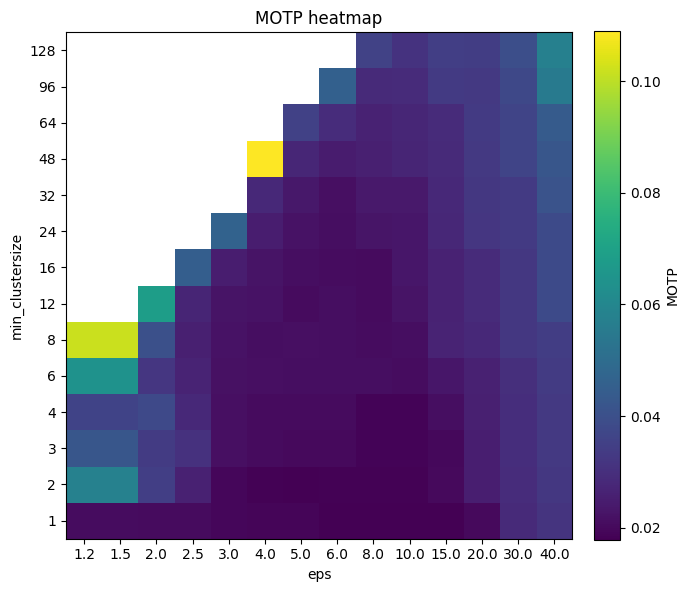

In [39]:
 # Heatmap: MOTA across (eps × min_clustersize)
fig = plot_heatmap(agg, metric="motp",
             title="",
                vmin=None, vmax=None)

plt.savefig(f"run_slurm/heatmap_{SIM}_snr{SNR}_{TRACKER}_nprev{N_PREV}_ds{DS}_motp.svg", dpi=150)